In [1]:
import pandas as pd
import os

print(" Loading merged dataset from Parquet...")
merged_df = pd.read_parquet("merged_eicu_data.parquet")
print(f"Loaded dataset with {merged_df.shape[0]:,} rows and {merged_df.shape[1]} columns.")

 Loading merged dataset from Parquet...
Loaded dataset with 1,908,519 rows and 58 columns.


In [2]:
print("Checking missing values in the dataset...")

missing_report = merged_df.isnull().sum()
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)

if missing_report.empty:
    print("No missing values found!")
else:
    print("Columns with missing values:")
    print(missing_report)

Checking missing values in the dataset...
Columns with missing values:
ventstartoffset    266081
ventendoffset      266081
dtype: int64


In [3]:
merged_df.columns

Index(['gender', 'age', 'admissionheight', 'hospitaladmitoffset',
       'hospitaldischargeoffset', 'admissionweight', 'urine', 'wbc',
       'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine',
       'albumin', 'pao2', 'pco2', 'bun', 'glucose', 'bilirubin',
       'acutephysiologyscore', 'apachescore', 'actualhospitalmortality',
       'admitsource', 'verbal', 'motor', 'admitdiagnosis', 'hepaticfailure',
       'metastaticcancer', 'leukemia', 'immunosuppression', 'diabetes',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
       'temperature', 'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean',
       'ventstartoffset', 'ventendoffset', 'LOS_days'],
      dtype='object')

In [4]:
print("Converting categorical features to numeric...")

categorical_cols = ["gender", "admitsource", "admitdiagnosis"]

from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # make sure it's str

print("Categorical features converted successfully!")

Converting categorical features to numeric...
Categorical features converted successfully!


In [5]:
print("Converting mortality labels to numeric...")


merged_df["actualhospitalmortality"] = merged_df["actualhospitalmortality"].replace({"Expired": 1, "Alive": 0})
merged_df["actualhospitalmortality"] = pd.to_numeric(merged_df["actualhospitalmortality"], errors="coerce")


merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)

print("Mortality labels cleaned and converted to numeric!")

Converting mortality labels to numeric...
Mortality labels cleaned and converted to numeric!


/var/folders/qb/06xhfcmx5yzc7t8swxtczfpw0000gn/T/ipykernel_40140/1910008520.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["actualhospitalmortality"].fillna(merged_df["actualhospitalmortality"].mode()[0], inplace=True)


In [6]:
# Drop pco2 as it's redundant
merged_df = merged_df.drop(columns=["pco2"], errors="ignore")

# Confirm removal
print("Removed `pco2` (high correlation with `ph`).")
print(f"Updated dataset shape: {merged_df.shape}")
print(f"Remaining columns: {list(merged_df.columns)}")

Removed `pco2` (high correlation with `ph`).
Updated dataset shape: (1908519, 57)
Remaining columns: ['gender', 'age', 'admissionheight', 'hospitaladmitoffset', 'hospitaldischargeoffset', 'admissionweight', 'urine', 'wbc', 'respiratoryrate', 'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'bun', 'glucose', 'bilirubin', 'acutephysiologyscore', 'apachescore', 'actualhospitalmortality', 'admitsource', 'verbal', 'motor', 'admitdiagnosis', 'hepaticfailure', 'metastaticcancer', 'leukemia', 'immunosuppression', 'diabetes', 'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride', 'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH', 'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium', 'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration', 'temperature', 'sao2', 'systemicdiastolic', 'systemicmean', 'systemicsystolic', 'intaketotal_mean', 'outputtotal_mean', 'ventstartoffset', 'ventendoffset', 'LOS_days']


In [7]:
expected_columns=['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'motor',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
        'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean','actualhospitalmortality']

merged_df = merged_df[expected_columns]

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

print("Checking DataFrame Type Before Computing...")

if isinstance(merged_df, dd.DataFrame):
    print("Converting from Dask to Pandas...")
    merged_df = merged_df.compute()
else:
    print("Already a Pandas DataFrame—skipping `.compute()`.")

target = "actualhospitalmortality"
X_d = merged_df.drop(columns=[target])
y_d = merged_df[target]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d, test_size=0.2, random_state=42, stratify=y_d
)

print(f"Data split completed: Train size = {X_train_d.shape}, Test size = {X_test_d.shape}")

Checking DataFrame Type Before Computing...
Already a Pandas DataFrame—skipping `.compute()`.
Data split completed: Train size = (1526815, 28), Test size = (381704, 28)


In [9]:
print("y_test_d unique values:")
print(y_test_d.unique())

print("\n y_test_d data type:", y_test_d.dtype)


y_test_d unique values:
[0. 1.]

 y_test_d data type: float64


In [10]:
y_test_d = y_test_d.astype(int)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

print("Checking DataFrame Type Before Computing...")

if isinstance(merged_df, dd.DataFrame):
    print(" Converting from Dask to Pandas...")
    merged_df = merged_df.compute()
else:
    print("Already a Pandas DataFrame—skipping `.compute()`.")

target = "actualhospitalmortality"
X_d = merged_df.drop(columns=[target])
y_d = merged_df[target]


X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d, test_size=0.2, random_state=42, stratify=y_d
)

print(f"Data split completed: Train size = {X_train_d.shape}, Test size = {X_test_d.shape}")

Checking DataFrame Type Before Computing...
Already a Pandas DataFrame—skipping `.compute()`.
Data split completed: Train size = (1526815, 28), Test size = (381704, 28)


In [12]:
import torch.nn as nn

class ICU_NN(nn.Module):
    def __init__(self, input_size):
        super(ICU_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x) 

In [13]:
import joblib
import torch
import xgboost as xgb

rf_model = joblib.load("random_forest_mimic.pkl")
logr_model = joblib.load("logistic_regression_mimic.pkl")
nb_model = joblib.load("naive_bayes_mimic.pkl")
knn_model = joblib.load("knn_mimic.pkl")
svc_model = joblib.load("linear_svc_calibrated_mimic.pkl")
xgb_model = joblib.load("xgb_mimic.pkl")

expected_columns=['age', 'admissionweight', 'respiratoryrate', 'ph', 'bun',
       'glucose', 'motor',
       'mean_BUN', 'mean_Hgb', 'mean_WBC x 1000', 'mean_chloride',
       'mean_creatinine', 'mean_glucose', 'mean_lactate', 'mean_pH',
       'mean_paCO2', 'mean_paO2', 'mean_platelets x 1000', 'mean_potassium',
       'mean_sodium', 'mean_total bilirubin', 'heartrate', 'respiration',
        'sao2', 'systemicdiastolic', 'systemicmean',
       'systemicsystolic', 'outputtotal_mean']


model = ICU_NN(len(expected_columns))
model.load_state_dict(torch.load("mimic_mortality.pth"))
model.eval()

ICU_NN(
  (fc1): Linear(in_features=28, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [14]:
import numpy as np

In [15]:

def evaluate_model_pretty(name, y_test, y_pred, y_prob, y, n_classes, results):
    if n_classes == 2:
        if y_prob.ndim == 2 and y_prob.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_prob.flatten())
    else:
        roc_auc = roc_auc_score(
            label_binarize(y_test, classes=np.unique(y)),
            y_prob,
            average='macro',
            multi_class='ovo'
        )

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    print("\n" + "="*80)
    print(f"Evaluation of {name} on Test Set:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  AUC-ROC  : {roc_auc:.4f}\n")
    print("Detailed Report:\n")
    print(classification_report(y_test, y_pred, digits=2))
    print("="*80 + "\n")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "ROC-AUC": roc_auc
    })

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize

In [17]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

logr_model_mim = joblib.load("logistic_regression_mimic.pkl")

y_pred_prob_logr = logr_model_mim.predict_proba(X_test_d)[:, 1]
y_pred_logr = (y_pred_prob_logr > 0.3).astype(int)
from sklearn.metrics import accuracy_score, precision_score, recall_score

mask = ~y_test_d.isna()
y_test_d_clean = y_test_d[mask].astype(int)
y_pred_logr_clean = y_pred_logr[mask]

accuracy = accuracy_score(y_test_d_clean, y_pred_logr_clean)
precision = precision_score(y_test_d_clean, y_pred_logr_clean)
recall = recall_score(y_test_d_clean, y_pred_logr_clean)
roc_auc = roc_auc_score(y_test_d_clean, y_pred_logr_clean)

print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")


 Accuracy: 0.7410
 Precision: 0.4107
 Recall: 0.4001
 AUC-ROC: 0.6188


In [18]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

nb_model_mim = joblib.load("naive_bayes_mimic.pkl")

y_pred_prob_nb = nb_model_mim.predict_proba(X_test_d)[:, 1]
y_pred_nb = (y_pred_prob_nb > 0.3).astype(int)

accuracy = accuracy_score(y_test_d, y_pred_nb)
precision = precision_score(y_test_d, y_pred_nb)
recall = recall_score(y_test_d, y_pred_nb)
roc_auc = roc_auc_score(y_test_d, y_pred_prob_nb)

print("Evaluation of MIMIC-Trained Gaussian Naive Bayes on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_nb))

Evaluation of MIMIC-Trained Gaussian Naive Bayes on eICU Test Set:
 Accuracy: 0.4691
 Precision: 0.2438
 Recall: 0.6690
 AUC-ROC: 0.5217

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.81      0.41      0.55    297498
         1.0       0.24      0.67      0.36     84206

    accuracy                           0.47    381704
   macro avg       0.53      0.54      0.45    381704
weighted avg       0.69      0.47      0.51    381704



In [19]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report


knn_model_mim = joblib.load("knn_mimic.pkl")


y_pred_prob_knn = knn_model_mim.predict_proba(X_test_d)[:, 1]
y_pred_knn = (y_pred_prob_knn > 0.3).astype(int)


accuracy = accuracy_score(y_test_d, y_pred_knn)
precision = precision_score(y_test_d, y_pred_knn)
recall = recall_score(y_test_d, y_pred_knn)
roc_auc = roc_auc_score(y_test_d, y_pred_prob_knn)

print("Evaluation of MIMIC-Trained KNN on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_knn))

Evaluation of MIMIC-Trained KNN on eICU Test Set:
 Accuracy: 0.5956
 Precision: 0.2657
 Recall: 0.4726
 AUC-ROC: 0.5770

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71    297498
         1.0       0.27      0.47      0.34     84206

    accuracy                           0.60    381704
   macro avg       0.54      0.55      0.52    381704
weighted avg       0.69      0.60      0.63    381704



In [20]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

svc_model_mim = joblib.load("linear_svc_calibrated_mimic.pkl")


y_pred_prob_svc = svc_model_mim.predict_proba(X_test_d)[:, 1]
y_pred_svc = (y_pred_prob_svc > 0.3).astype(int)


accuracy = accuracy_score(y_test_d, y_pred_svc)
precision = precision_score(y_test_d, y_pred_svc)
recall = recall_score(y_test_d, y_pred_svc)
roc_auc = roc_auc_score(y_test_d, y_pred_prob_svc)

print("Evaluation of MIMIC-Trained LinearSVC + Calibration on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_svc))

Evaluation of MIMIC-Trained LinearSVC + Calibration on eICU Test Set:
 Accuracy: 0.7427
 Precision: 0.4033
 Recall: 0.3468
 AUC-ROC: 0.6677

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84    297498
         1.0       0.40      0.35      0.37     84206

    accuracy                           0.74    381704
   macro avg       0.61      0.60      0.61    381704
weighted avg       0.73      0.74      0.74    381704



In [21]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report


rf_model_mim = joblib.load("random_forest_mimic.pkl")


y_pred_prob_rf = rf_model_mim.predict_proba(X_test_d)[:, 1]
y_pred_rf = (y_pred_prob_rf > 0.3).astype(int) 


accuracy = accuracy_score(y_test_d, y_pred_rf)
precision = precision_score(y_test_d, y_pred_rf)
recall = recall_score(y_test_d, y_pred_rf)
roc_auc = roc_auc_score(y_test_d, y_pred_prob_rf)



print("Evaluation of MIMIC-Trained Random Forest on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_rf))

Evaluation of MIMIC-Trained Random Forest on eICU Test Set:
 Accuracy: 0.7252
 Precision: 0.4088
 Recall: 0.5506
 AUC-ROC: 0.7482

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81    297498
         1.0       0.41      0.55      0.47     84206

    accuracy                           0.73    381704
   macro avg       0.63      0.66      0.64    381704
weighted avg       0.76      0.73      0.74    381704



In [22]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report


xgb_model_simple = joblib.load("xgb_simple_model.pkl")


y_pred_xgb_d = xgb_model_simple.predict(X_test_d)
y_prob_xgb_d = xgb_model_simple.predict_proba(X_test_d)[:, 1]


accuracy = accuracy_score(y_test_d, y_pred_xgb_d)
precision = precision_score(y_test_d, y_pred_xgb_d)
recall = recall_score(y_test_d, y_pred_xgb_d)
roc_auc = roc_auc_score(y_test_d, y_prob_xgb_d)

y_pred_xgb_d = (y_prob_xgb_d > 0.3).astype(int)

print(" Evaluation of XGBoost (Default Params) on eICU Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nDetailed Report:\n")
print(classification_report(y_test_d, y_pred_xgb_d))


 Evaluation of XGBoost (Default Params) on eICU Test Data:
Accuracy: 0.7436
Precision: 0.4270
Recall: 0.4737
AUC-ROC: 0.7546

Detailed Report:

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81    297498
         1.0       0.41      0.58      0.48     84206

    accuracy                           0.72    381704
   macro avg       0.64      0.67      0.65    381704
weighted avg       0.77      0.72      0.74    381704



In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report


import joblib

xgb_model_mim = joblib.load("xgb_mimic.pkl", mmap_mode='r')
print(" XGBoost model loaded successfully using memory mapping!")


y_pred_prob_d = xgb_model_mim.predict_proba(X_test_d)[:, 1]  
y_pred_d = (y_pred_prob_d > 0.3).astype(int)  


accuracy = accuracy_score(y_test_d, y_pred_d)
precision = precision_score(y_test_d, y_pred_d)
recall = recall_score(y_test_d, y_pred_d)
roc_auc = roc_auc_score(y_test_d, y_pred_prob_d)

print("Evaluation of MIMIC-Trained XGBoost on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_d))

 XGBoost model loaded successfully using memory mapping!
Evaluation of MIMIC-Trained XGBoost on eICU Test Set:
 Accuracy: 0.7399
 Precision: 0.4342
 Recall: 0.5912
 AUC-ROC: 0.7696

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82    297498
         1.0       0.43      0.59      0.50     84206

    accuracy                           0.74    381704
   macro avg       0.65      0.69      0.66    381704
weighted avg       0.77      0.74      0.75    381704



In [24]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score


class ICU_NN(nn.Module):
    def __init__(self, input_size):
        super(ICU_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

input_dim = X_train_d.shape[1]  
model = ICU_NN(input_size=input_dim)
model.load_state_dict(torch.load("mimic_mortality.pth", map_location=torch.device("cpu")))
model.eval()

scaler = StandardScaler()
scaler.fit(X_train_d)  
X_eicu_scaled = scaler.transform(X_test_d)  


X_eicu_tensor = torch.tensor(X_eicu_scaled, dtype=torch.float32)
y_eicu_true = torch.tensor(y_test_d.values, dtype=torch.float32)


with torch.no_grad():
    logits = model(X_eicu_tensor)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.3).float()


print("Evaluation of MIMIC-Trained Neural Network on eICU Test Set:")
print(f"Accuracy: {accuracy_score(y_eicu_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_eicu_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_eicu_true, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_eicu_true, probs):.4f}")
print("\nDetailed Report:\n")
print(classification_report(y_eicu_true, y_pred))

Evaluation of MIMIC-Trained Neural Network on eICU Test Set:
Accuracy: 0.6265
Precision: 0.3320
Recall: 0.6845
AUC-ROC: 0.7162

Detailed Report:

              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72    297498
         1.0       0.33      0.68      0.45     84206

    accuracy                           0.63    381704
   macro avg       0.60      0.65      0.58    381704
weighted avg       0.75      0.63      0.66    381704



In [25]:

y_prob_xgb_d = xgb_model.predict_proba(X_test_d)[:, 1] 


X_scaled_d = scaler.transform(X_test_d)
X_tensor_d = torch.tensor(X_scaled_d, dtype=torch.float32)

with torch.no_grad():
    nn_logits = model(X_tensor_d)
    y_prob_nn_d = torch.sigmoid(nn_logits).numpy().flatten()

ensemble_prob_d = (y_prob_nn_d + y_prob_xgb_d) / 2.0
ensemble_pred_d = (ensemble_prob_d > 0.3).astype(int)


from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test_d, ensemble_pred_d)
precision = precision_score(y_test_d, ensemble_pred_d)
recall = recall_score(y_test_d, ensemble_pred_d)
roc_auc = roc_auc_score(y_test_d, ensemble_prob_d)

print(" Evaluation of Combined Ensemble Model on eICU Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nDetailed Report:\n")
print(classification_report(y_test_d, ensemble_pred_d))

 Evaluation of Combined Ensemble Model on eICU Test Set:
Accuracy: 0.6821
Precision: 0.3838
Recall: 0.7284
AUC-ROC: 0.7690

Detailed Report:

              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77    297498
         1.0       0.38      0.73      0.50     84206

    accuracy                           0.68    381704
   macro avg       0.64      0.70      0.63    381704
weighted avg       0.78      0.68      0.71    381704



In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# Load models
import joblib
xgb_model_mim = joblib.load("xgb_mimic.pkl", mmap_mode='r')
rf_model_mim = joblib.load("random_forest_mimic.pkl")

# Predict probabilities
y_prob_xgb = xgb_model_mim.predict_proba(X_test_d)[:, 1]
y_prob_rf = rf_model_mim.predict_proba(X_test_d)[:, 1]

# Combine predictions using soft voting (equal weight or adjust if needed)
ensemble_prob = (y_prob_xgb + y_prob_rf) / 2  # or use weights: (0.6 * xgb + 0.4 * rf)

# Apply threshold
y_pred_ensemble = (ensemble_prob > 0.3).astype(int)

# Evaluate
accuracy = accuracy_score(y_test_d, y_pred_ensemble)
precision = precision_score(y_test_d, y_pred_ensemble)
recall = recall_score(y_test_d, y_pred_ensemble)
roc_auc = roc_auc_score(y_test_d, ensemble_prob)

print("Evaluation of RF + XGBoost Ensemble on eICU Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" AUC-ROC: {roc_auc:.4f}")
print("\n Detailed Report:\n")
print(classification_report(y_test_d, y_pred_ensemble))

Evaluation of RF + XGBoost Ensemble on eICU Test Set:
 Accuracy: 0.7331
 Precision: 0.4239
 Recall: 0.5846
 AUC-ROC: 0.7635

 Detailed Report:

              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82    297498
         1.0       0.42      0.58      0.49     84206

    accuracy                           0.73    381704
   macro avg       0.65      0.68      0.66    381704
weighted avg       0.77      0.73      0.75    381704



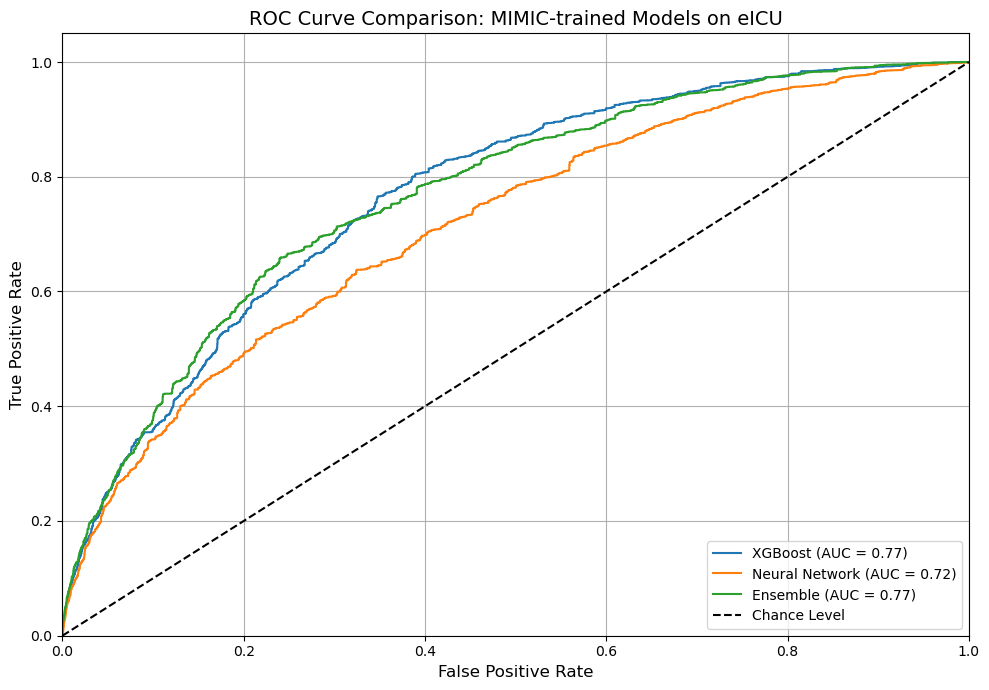

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



import numpy as np
y_prob_nn_d = probs.numpy().flatten()


fpr_xgb, tpr_xgb, _ = roc_curve(y_test_d, y_pred_prob_d)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_nn, tpr_nn, _ = roc_curve(y_test_d, y_prob_nn_d)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_ens, tpr_ens, _ = roc_curve(y_test_d, ensemble_prob_d)
roc_auc_ens = auc(fpr_ens, tpr_ens)


plt.figure(figsize=(10, 7))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: MIMIC-trained Models on eICU', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


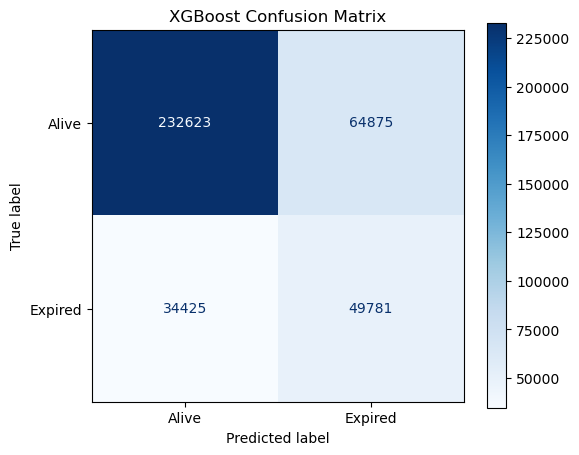

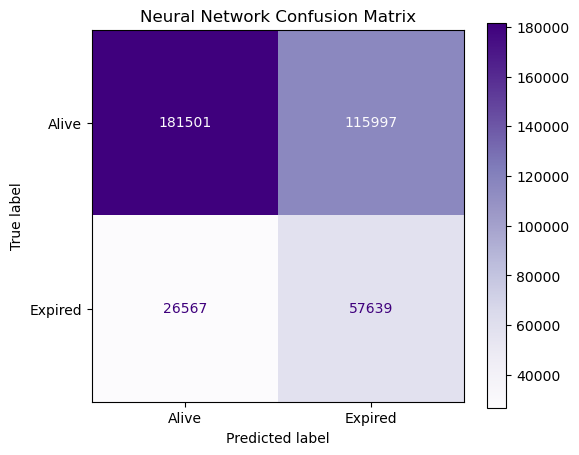

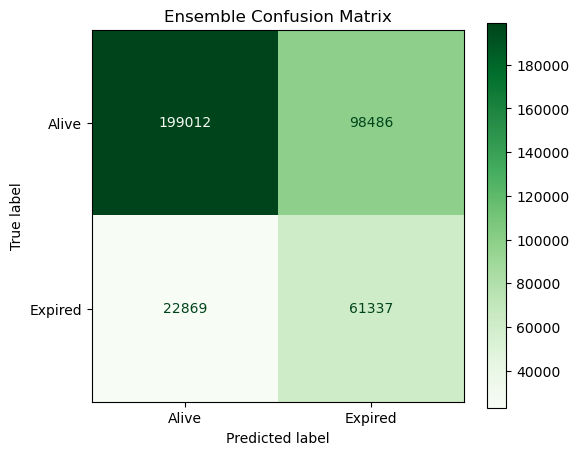

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_xgb = (y_pred_prob_d > 0.3).astype(int)
cm_xgb = confusion_matrix(y_test_d, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Alive", "Expired"])
fig1, ax1 = plt.subplots(figsize=(6, 5))
disp_xgb.plot(ax=ax1, cmap="Blues", values_format='d')
plt.title("XGBoost Confusion Matrix")

y_pred_nn = (y_prob_nn_d > 0.3).astype(int)
cm_nn = confusion_matrix(y_test_d, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=["Alive", "Expired"])
fig2, ax2 = plt.subplots(figsize=(6, 5))
disp_nn.plot(ax=ax2, cmap="Purples", values_format='d')
plt.title("Neural Network Confusion Matrix")

y_pred_ensemble = (ensemble_prob_d > 0.3).astype(int)
cm_ensemble = confusion_matrix(y_test_d, y_pred_ensemble)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=["Alive", "Expired"])
fig3, ax3 = plt.subplots(figsize=(6, 5))
disp_ensemble.plot(ax=ax3, cmap="Greens", values_format='d')
plt.title("Ensemble Confusion Matrix")

plt.show()


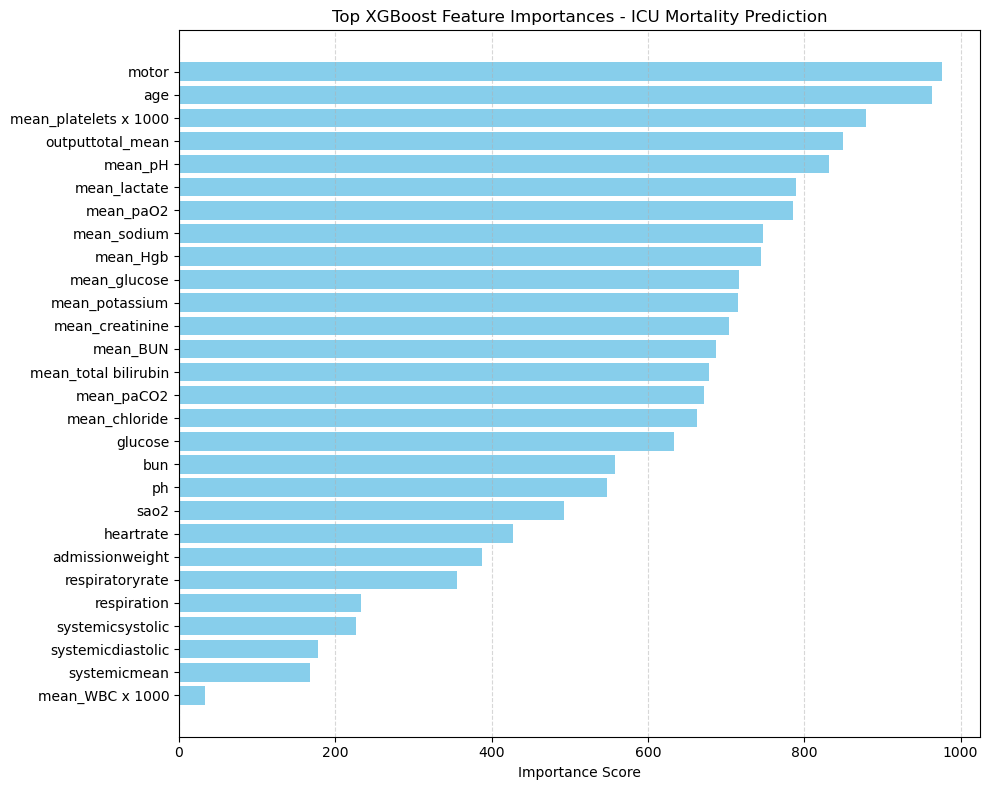

In [29]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd

model = joblib.load("xgb_mimic.pkl")

booster = model.get_booster()
importance = booster.get_score(importance_type='weight')

importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

importance_df = importance_df.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.title("Top XGBoost Feature Importances - ICU Mortality Prediction")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

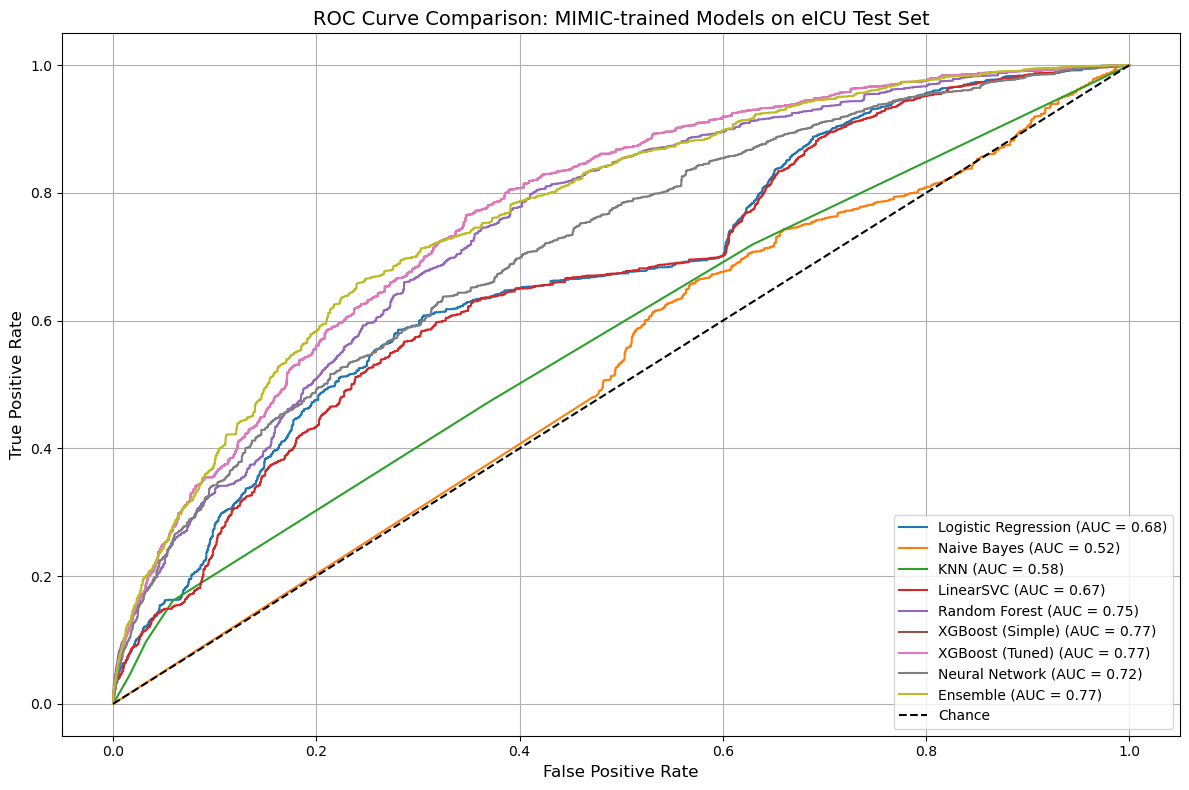

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_logr, tpr_logr, _ = roc_curve(y_test_d, y_pred_prob_logr)
roc_auc_logr = auc(fpr_logr, tpr_logr)

fpr_nb, tpr_nb, _ = roc_curve(y_test_d, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_knn, tpr_knn, _ = roc_curve(y_test_d, y_pred_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_svc, tpr_svc, _ = roc_curve(y_test_d, y_pred_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_rf, tpr_rf, _ = roc_curve(y_test_d, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb_simple, tpr_xgb_simple, _ = roc_curve(y_test_d, y_prob_xgb_d)
roc_auc_xgb_simple = auc(fpr_xgb_simple, tpr_xgb_simple)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test_d, y_pred_prob_d)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_nn, tpr_nn, _ = roc_curve(y_test_d, y_prob_nn_d)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_ens, tpr_ens, _ = roc_curve(y_test_d, ensemble_prob_d)
roc_auc_ens = auc(fpr_ens, tpr_ens)

plt.figure(figsize=(12, 8))
plt.plot(fpr_logr, tpr_logr, label=f'Logistic Regression (AUC = {roc_auc_logr:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_svc, tpr_svc, label=f'LinearSVC (AUC = {roc_auc_svc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb_simple, tpr_xgb_simple, label=f'XGBoost (Simple) (AUC = {roc_auc_xgb_simple:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (Tuned) (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {roc_auc_ens:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison: MIMIC-trained Models on eICU Test Set", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()